In [1]:
#Dependencies
import os
import numpy as np
import pylab as pl
import tensorflow as tf
import matplotlib.pyplot as plt

import utils.plotutils as plu
import utils.imreadin as imr
import utils.animutils as aniu

%matplotlib inline

In [355]:
#Model Parameters

tanh_model = 0
relu_model = 0
sigmoid_model = 1

#network params
compression = 5
patchsize = 16

#training params
batchsize = 1000
iterations = 4000
epochs = 3

if(tanh_model):
    noisexsigma = 0
    noisersigma = 0
    minact = 0
    minslo = 0 
    learning_rate = 0.01
    model_type = 'tanh'
elif(relu_model):
    noisexsigma = 0.01
    noisersigma = 0.5
    minact = 0
    minslo = 0 
    learning_rate = 0.01
    model_type = 'relu'
elif(sigmoid_model):
    #noise
    noisexsigma = 0.01
    noisersigma = 0.03
    minact = 0 
    minslo = 0
    learning_rate = 0.01
    model_type = 'sigmoid'
else:
    raise ValueError('No model specified!')

In [356]:
#Load in images if we haven't yet.

def loadimages(psz):
    print("Loading Van Hateren Natural Image Database...")
    vhimgs = imr.vanHateren(
        img_dir='../vanHaterenNaturalImages/VanHaterenNaturalImagesCurated.h5',
        #normalize=True,
        normalize_im = True,
        normalize_patch = False,
        patch_edge_size=psz
        )
    print("Done Loading!")    
    np.random.shuffle(vhimgs.images)
    print("Done Shuffling!")
    return(vhimgs, psz)

try:
    vhims
except NameError:
    vhims, loadedpatchsize = loadimages(patchsize)
    
if(patchsize != loadedpatchsize):
    vhims, loadedpatchsize = loadimages(patchsize)
       
print("Images Loaded.")

#params of images
imxlen = len(vhims.images[0,0,:])
imylen = len(vhims.images[0,:,0])
nimages = len(vhims.images[:,0,0])

nimstrained = batchsize * iterations

if(nimstrained > nimages):
    print('ERROR! Trying to train',nimstrained,'images, but we only have',nimages,'images!')
else:
    print('Training',nimstrained,'out of',nimages,'total image patches.')

Images Loaded.
Training 4000000 out of 4685824 total image patches.


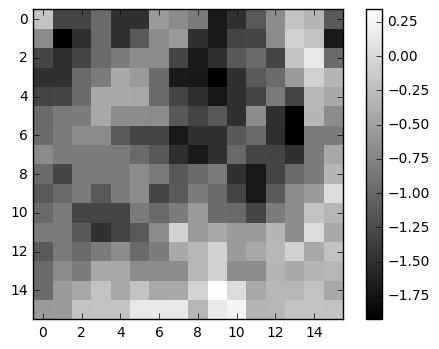

In [357]:
#show an example image
plt.imshow(vhims.images[100],cmap='gray',interpolation='none')
plt.colorbar()

In [358]:
nneurons = np.int(imxlen*imylen/compression)
print('Compressing by',compression,'for a total of',nneurons,'neurons')
savefolder = str('./output/actfun_'+model_type+'/neurons_'+str(nneurons)+'/noise_in_'+str(noisexsigma)+'_out_'+str(noisersigma)+'/')
if not os.path.exists(savefolder):
    os.makedirs(savefolder)

#setup our graph
    
#input image
x = tf.placeholder(tf.float32, shape=(batchsize, imxlen*imylen),name='input_image')

#activation function type
act_fun = tf.placeholder(tf.string, name= 'activation_function')

#noise
nxc = noisexsigma**2
nrc = noisersigma**2
nx = tf.constant(nxc,dtype=tf.float32,name='input_noise')
nr = tf.constant(nrc,dtype=tf.float32,name='internal_noise')

#weights
win = tf.Variable(tf.random_normal([imxlen*imylen,nneurons],dtype=tf.float32,stddev=0.1),name='weights_in')
#wout = tf.Variable(tf.random_normal([nneurons,imxlen*imylen],dtype=tf.float32,stddev=0.01),name='weights_out')

#bias
bias = tf.Variable(tf.random_normal([nneurons],dtype=tf.float32,stddev=0.1),name='bias')

#define nonlinearities
def tanh_fun(arg):
    return tf.nn.tanh(arg) 
def sigmoid_fun(arg):
    return tf.nn.sigmoid(arg) 
def relu_fun(arg):
    return tf.nn.relu(arg) 
def no_fun(arg):
    return arg

#calculate input
linearin = tf.add(tf.matmul(tf.add(x,nx),win),bias)
yin = tf.case({tf.equal(act_fun,'tanh'): (lambda: tanh_fun(linearin)),
               tf.equal(act_fun,'sigmoid'): (lambda: sigmoid_fun(linearin)),
               tf.equal(act_fun,'relu'): (lambda: relu_fun(linearin))},
              default=(lambda: no_fun(linearin)),
              exclusive=True, name = 'input_nonlinearity')

#calculate output
linearout = tf.matmul(yin,tf.transpose(win))
yout = tf.case({tf.equal(act_fun,'tanh'): (lambda: tanh_fun(linearout)),
                tf.equal(act_fun,'sigmoid'): (lambda: sigmoid_fun(linearout)),
                tf.equal(act_fun,'relu'): (lambda: relu_fun(linearout))},
               default=(lambda: no_fun(linearout)),
               exclusive=True, name='output_nonlienarity')

#calculate reconstruction
xp = tf.add(yout,nr)

#calculate cost
cost = tf.sqrt(tf.reduce_mean(tf.square(x-xp)))

train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Compressing by 5 for a total of 51 neurons


In [ ]:




#run it!
#sess = tf.Session
with tf.Session() as sess:
    #initialize vars
    init = tf.global_variables_initializer()
    sess.run(init)
    
    #save evolution of system over training
    cost_evolution = []
    wmean_evolution = []
    
    weights_evolution = []
    images = []
    recons = []
    
    #train over niterations
    nits = iterations #full run
    
    print('Training {} iterations in {} epochs...'.format(nits, epochs))
    for epoch in range(epochs):
        print('\nEpoch {}: '.format(epoch+1))
        np.random.shuffle(vhims.images)
        for ii in range(nits):
            image = np.reshape(vhims.images[ii*batchsize:(1+ii)*batchsize,:,:],(batchsize,imxlen*imylen)).astype(np.float32)
            #noise_input = np.random.normal(0,noisexsigma,[patchsize**2,batchsize]).astype(np.float32)*0.
            #noise_response = np.random.normal(0,noisersigma,[nneurons,batchsize]).astype(np.float32)*0.
            sess.run(train_step, feed_dict={x:image, act_fun:model_type})

            #save evolution of params
            objcost, wmean = sess.run([cost,win], feed_dict={x:image, act_fun:model_type})
            cost_evolution.append(objcost)
            wmean_evolution.append(np.mean(wmean))
            
            if(ii%(int((nits)/10))==0):
                print(str(ii)+', ',end="")
                #dump our weights
                w = sess.run(win, feed_dict={x:image, act_fun:model_type})
                weights_evolution.append(w)
                #and save our image and reconstruction
                images.append(np.reshape(image,[batchsize,imxlen,imylen]))
                recons.append(np.reshape(sess.run(xp, feed_dict={x:image, act_fun:model_type}),[batchsize,imxlen,imylen]))
                
    
    final_weights = sess.run(win, feed_dict={x:image, act_fun:model_type})
    print('\nDone!')

Training 4000 iterations in 3 epochs...

Epoch 1: 
0, 400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 

In [ ]:
#Show our final weights
#wr = np.rollaxis(np.reshape(final_weights,(imxlen,imylen,nneurons)),2)
#im = plu.display_data_tiled(wr, normalize=False, title="final_weights", prev_fig=None)

#Show our final weights
weights_evolution_r = np.rollaxis(np.reshape(weights_evolution,(len(weights_evolution),imxlen,imylen,nneurons)),3,1)
(f,sa,ai) = plu.display_data_tiled(weights_evolution_r[-1], normalize=False, title="final_weights", prev_fig=None)
f.savefig(savefolder+'weights_final.png') 

In [ ]:
#save figures
for i in range(len(weights_evolution_r)):
    (f,sa,ai) = plu.display_data_tiled(weights_evolution_r[i], normalize=False,title="weights_evolving", prev_fig=None)
    f.savefig(savefolder+'/weights_evolution_'+str(i)+'.png') 

In [ ]:
f2 = plt.figure(figsize=(6,6))

plt.subplot(2,1,1,title='Weights')
plt.plot(wmean_evolution)

plt.subplot(2,1,2,title='Objective')
plt.plot(cost_evolution)

plt.tight_layout()

f2.savefig(savefolder+'/cost_weights.png') 

In [ ]:
#show an example image and reconstruction from the last iteration of learning
patchnum = 3

plots = 4
for i in range(plots):
    plt.subplot(plots,2,2*i+1)#,title='Patch')
    plt.imshow(images[-1][patchnum+i],cmap='gray',interpolation='none')
    plt.axis('off')
    
    plt.subplot(plots,2,2*i+2)#,title='Recon')
    plt.imshow(recons[-1][patchnum+i],cmap='gray',interpolation='none')
    plt.axis('off')


plt.tight_layout()
plt.savefig(savefolder+'/reconstruction.png') 

code to plot the tiling of on and off RFs - for now opencv isn't working

In [353]:
def plotonoff(allws):
    
    #allws = weights
    #get on center
    onws = np.mean(allws,axis=0)>0
    onws = allws[:,onws]
    #get off center
    offws = np.mean(allws,axis=0)<0
    offws = allws[:,offws]
    #keep track of the circles
    oncircs = []
    offcircs = []

    #blank 16x16 to draw circles
    onrfs = np.zeros_like(weights_evolution_r[-1][0])
    offrfs = np.zeros_like(weights_evolution_r[-1][0])

    for ws in allws:
        circ = (ws>(0.99*np.sign(np.mean(ws))))
        if(np.mean(ws)>0):
            oncircs.append(circ)
        else:
            offcircs.append(False==circ)

    print(type(offcircs[1]))
#     plt.pcolormesh(oncircs[1])
#     plt.colorbar()
    
    #plot
    plt.figure(figsize=(6,3.5))
    plt.subplot(1,2,1,title='On')    
    oncolors = iter(plt.cm.jet(np.linspace(0,1,len(oncircs))))           
    for onc in oncircs: 
        plt.contour(onc,[0.7],linewidths = 5,colors=[next(oncolors)])
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(1,2,2,title='Off')
    offcolors = iter(plt.cm.jet(np.linspace(0,1,len(offcircs))))  
    for ofc in offcircs:
        plt.contour(ofc,[.7], linewidths = 5, colors=[next(offcolors)])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    

<class 'numpy.ndarray'>


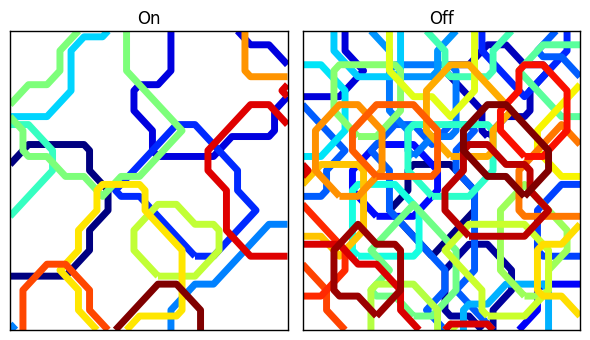

In [354]:
plotonoff(weights_evolution_r[-1])

In [ ]:
print(weights[1])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

## Autoencoder Math

